# Sparkify

## 概述
Sparkify是一家数字音乐服务的公司，大量用户每天使用该服务听自己喜欢的歌曲，他们可能是带广告的免费用户，或是使用尊贵会员的用户，会员听歌免费但是需要按月支付一定费用，用户可以升级降级，注销其账号。如果用户在平台体验不好，或需求没有得到满足，他们可能会流失(churn)，要在用户流失之前留住他们

**为什么要预测用户流失？**

此notebook尝试预测哪些用户可能会流失，如果在用户流失之前用某种方式留住他们(例如打折)，就能避免损失营业额。

**如何预测用户流失？**

我们假设现有数据代表sparkify平台上用户的一种模式，在现有数据上构建的模型可以泛化到其他用户。为了预测平台用户的流失，需要在现有数上构建了模型。具体来说，步骤是大致遵循加载数据集，清理数据，探索数据，提取特征，创建模型，最后用模型预测用户流失。

## 数据
用户每次和Sparkify服务互动都会产生用户行为数据，例如听歌曲，访问页面，添加好友，点赞等。完整的数据是12G，此notebook使用数据的一个子集(128M)，在非集群环境运行。

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, expr, col, isnan, max, avg, min, count, countDistinct, sqrt, lit, when, isnull
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import regexp_extract
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier
from pyspark.ml import Pipeline
import sklearn.metrics as metrics
import pandas as pd

from pyspark.sql.types import IntegerType, FloatType
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import datetime
from time import time

base_color = sb.color_palette()[0]
sb.set_style("whitegrid")

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

## 清洗数据

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
df.printSchema()
print('数据集有{}行，{}列。'.format(df.count(), len(df.columns)))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

数据集有286500行，18列。


In [4]:
# 查看缺失值比率
df.select([(count(when(isnull(c), c))/df.count()).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-----------------------------
 artist        | 0.20381151832460734  
 auth          | 0.0                  
 firstName     | 0.029130890052356022 
 gender        | 0.029130890052356022 
 itemInSession | 0.0                  
 lastName      | 0.029130890052356022 
 length        | 0.20381151832460734  
 level         | 0.0                  
 location      | 0.029130890052356022 
 method        | 0.0                  
 page          | 0.0                  
 registration  | 0.029130890052356022 
 sessionId     | 0.0                  
 song          | 0.20381151832460734  
 status        | 0.0                  
 ts            | 0.0                  
 userAgent     | 0.029130890052356022 
 userId        | 0.0                  



上边观察到，artist / length / song的缺失比率一样，firstName / gender / lastName / location / registration / userAgent缺失比率一样，通过给这些行添加索引号，对比索引号发现它们缺失的是相同的行

In [5]:
# 定义一个比较两个列是否一致的函数
def column_consistent(df, kvs, how='inner'):
    '''
    INPUT
    df - spark DataFrame
    kvs - pair of column and value, compare two column's consistency. type:dict
          available dict key: columns in df.columns
          available dict value: 'null' / 'notnull' / 'nan' / 'value|value' / string / !string / number
          eg. {'animal':'human','like':'money'}: all human like money，all like mone are human
    how - inner / outer / left / right
    
    OUTPUT
    return the consistency of two columns.
    
    '''
    ks = list(kvs.keys())
    vs = list(kvs.values())
    df_index = df.select("*").withColumn("index", monotonically_increasing_id())
    switch = {
        "null": lambda *args: df_index[args[0]].isNull(),
        "nan": lambda *args: isnan(df_index[args[0]]),
        'notnull': lambda *args: df_index[args[0]].isNotNull(),
        'isin': lambda *args: df_index[args[0]].isin(args[1].split('|')),
    }
    id_pair = {
                k : df_index\
               .select(col('index').alias('{}={}_index'.format(k,v)))\
               .where((switch.get('isin' if '|' in v else v, lambda *args:df_index[args[0]]!=args[1].strip('!') if '!' in args[1] else df_index[args[0]]==args[1]))(k,v)) \
               for k,v in kvs.items()
              }
    result = id_pair[ks[0]].join(id_pair[ks[1]], id_pair[ks[0]]['{}={}_index'.format(ks[0],vs[0])]==id_pair[ks[1]]['{}={}_index'.format(ks[1],vs[1])], 'outer')
    if result.where(result[result.columns[0]].isNull() | result[result.columns[1]].isNull()).count() == 0:
        print('if "{}={}", then "{}={}". if "{}={}", then "{}={}".'.format(ks[0], vs[0], ks[1], vs[1], ks[1], vs[1], ks[0],vs[0]))
    if how == 'inner':
        return result.where(result[result.columns[0]].isNotNull() & result[result.columns[1]].isNotNull())
    if how == 'outer':
        return result
    if how == 'left':
        return result.where(result[result.columns[0]].isNotNull())
    if how == 'right':
        return result.where(result[result.columns[1]].isNotNull())

In [6]:
# artist缺失，length缺失，song缺失的行是相同
column_consistent(df, {'artist':'null', 'length':'null'})
column_consistent(df, {'length':'null', 'song':'null'})

if "artist=null", then "length=null". if "length=null", then "artist=null".
if "length=null", then "song=null". if "song=null", then "length=null".


DataFrame[length=null_index: bigint, song=null_index: bigint]

In [7]:
# firstname缺失，gender缺失，lastname缺失，location缺失，registration缺失，userAgent缺失的行是相同的
column_consistent(df, {'firstname':'null', 'gender':'null'})
column_consistent(df, {'gender':'null', 'lastname':'null'})
column_consistent(df, {'lastname':'null', 'location':'null'})
column_consistent(df, {'location':'null', 'registration':'null'})
column_consistent(df, {'registration':'null', 'userAgent':'null'})

if "firstname=null", then "gender=null". if "gender=null", then "firstname=null".
if "gender=null", then "lastname=null". if "lastname=null", then "gender=null".
if "lastname=null", then "location=null". if "location=null", then "lastname=null".
if "location=null", then "registration=null". if "registration=null", then "location=null".
if "registration=null", then "userAgent=null". if "userAgent=null", then "registration=null".


DataFrame[registration=null_index: bigint, userAgent=null_index: bigint]

page=Cancellation Confirmation的行 和 auth=Cancelled的行是相同的

In [8]:
column_consistent(df, {'page':'Cancellation Confirmation', 'auth':'Cancelled'})

if "page=Cancellation Confirmation", then "auth=Cancelled". if "auth=Cancelled", then "page=Cancellation Confirmation".


DataFrame[page=Cancellation Confirmation_index: bigint, auth=Cancelled_index: bigint]

详细看一下artist和length和song有缺失值的行，发现这些用户处在没有听任何歌曲的状态(song=None)

In [9]:
df.where((df['artist'].isNull())).take(5)

[Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=54, lastName='Freeman', length=None, level='paid', location='Bakersfield, CA', method='PUT', page='Add to Playlist', registration=1538173362000, sessionId=29, song=None, status=200, ts=1538352905000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=84, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='GET', page='Roll Advert', registration=1538331630000, sessionId=8, song=None, status=200, ts=1538353150000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=86, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='T

详细看下firstName和gender和lastName和location和registration和userAgen有缺失值的行，发现这些是没有注册的游客(registration=None)

In [10]:
df.where((df['firstName'].isNull())).take(5)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='free', location=None, method='PUT', page='Login', registration=None, s

userId存在空字符串的行

In [11]:
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [12]:
column_consistent(df, {'userId':'', 'registration':'null'})

if "userId=", then "registration=null". if "registration=null", then "userId=".


DataFrame[userId=_index: bigint, registration=null_index: bigint]

userId是空字符串的数量与游客数量相等，且是相同的行

In [13]:
print('数据中userId是空字符串的数量是： {}'.format(df.where(df.userId == '').count()))
print('游客的数量是：', df.where(df.registration.isNull()).count())
column_consistent(df, {'userId':'','registration':'null'})

数据中userId是空字符串的数量是： 8346
游客的数量是： 8346
if "userId=", then "registration=null". if "registration=null", then "userId=".


DataFrame[userId=_index: bigint, registration=null_index: bigint]

业务理解1：分别抽取几个访问过Cancellation Confirmation页面的付费和免费用户(游客不会访问Cancellation Confirmation页面)，观察他们访问Cancellation Confirmation页面之后的行为，发现在访问Cancellation Confirmation之后，就没有任何活动了，可以理解为用户注销了，或者用户churn。

In [14]:
# 筛选出访问过Cancellation Confirmation的paid和free用户
df.select('userId','level').where(df.level=='paid').where(df.page=='Cancellation Confirmation').show(5)
df.select('userId','level').where(df.level=='free').where(df.page=='Cancellation Confirmation').show(5)

+------+-----+
|userId|level|
+------+-----+
|    18| paid|
|    32| paid|
|   105| paid|
|    17| paid|
|   101| paid|
+------+-----+
only showing top 5 rows

+------+-----+
|userId|level|
+------+-----+
|   125| free|
|   143| free|
|100011| free|
|100001| free|
|100024| free|
+------+-----+
only showing top 5 rows



In [15]:
# 查看paid用户userId=18最后的活动
df.select('level','page').where(df.userId=='18').collect()[-5:]

[Row(level='paid', page='NextSong'),
 Row(level='paid', page='NextSong'),
 Row(level='paid', page='Downgrade'),
 Row(level='paid', page='Cancel'),
 Row(level='paid', page='Cancellation Confirmation')]

In [16]:
# 查看paid用户userId=32最后的活动
df.select('level','page').where(df.userId=='32').collect()[-5:]

[Row(level='paid', page='NextSong'),
 Row(level='paid', page='NextSong'),
 Row(level='paid', page='Downgrade'),
 Row(level='paid', page='Cancel'),
 Row(level='paid', page='Cancellation Confirmation')]

In [17]:
# 查看free用户userId=125最后的活动
df.select('level','page').where(df.userId=='125').collect()[-5:]

[Row(level='free', page='NextSong'),
 Row(level='free', page='NextSong'),
 Row(level='free', page='Roll Advert'),
 Row(level='free', page='Cancel'),
 Row(level='free', page='Cancellation Confirmation')]

In [18]:
# 查看free用户userId=143最后的活动
df.select('level','page').where(df.userId=='143').collect()[-5:]

[Row(level='free', page='NextSong'),
 Row(level='free', page='NextSong'),
 Row(level='free', page='Settings'),
 Row(level='free', page='Cancel'),
 Row(level='free', page='Cancellation Confirmation')]

业务理解2：游客的level也可以是paid，可能是游客购买了单曲，被标识为了paid用户

In [19]:
# 查看level是paid，用户名是空字符串的记录
df.select('userId','level','registration').where(df.userId=='').where(df.level=='paid').show(5)

+------+-----+------------+
|userId|level|registration|
+------+-----+------------+
|      | paid|        null|
|      | paid|        null|
|      | paid|        null|
|      | paid|        null|
|      | paid|        null|
+------+-----+------------+
only showing top 5 rows



由于游客永远不会访问Cancellation Confirmation，对于预测churn来说没有意义，将游客的数据删除

In [20]:
# 删除registration是空的行，即删除游客的记录
df_valid = df.dropna(subset='registration')
df_valid.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



数中的ts是unix时间戳形式，将其转换为可读时间，并提取其中的星期和小时，保存到新的列

In [21]:
# 将时间戳转为可读形式
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid = df_valid.withColumn('ts_readable', convert_ts('ts'))
# 提取时间戳中的小时
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_valid = df_valid.withColumn("hour", get_hour(df.ts).cast('int'))
# 提取时间戳中的星期
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday())
df_valid = df_valid.withColumn('week', get_hour(df.ts).cast('int'))

提取location中的州，保存到location_state

In [22]:
df_valid = df_valid.withColumn('location_state', regexp_extract('location',',(.*)',1))

In [23]:
print('清洗后数据集有{}行，{}列'.format(df_valid.count(), len(df_valid.columns)))

清洗后数据集有278154行，22列


## 探索数据

In [24]:
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_readable: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- location_state: string (nullable = true)



In [25]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### 定义churn

In [26]:
# 添加新列churn_page，如果page=Cancellation Confirmation，churn_page=1
transform_churn = udf(lambda x:1 if x=='Cancellation Confirmation' else 0, IntegerType())
df_valid = df_valid.withColumn('churn_page', transform_churn('page'))
# 按用户分组，根据churn_page得到用户是否流失(churn列)
windowval = Window.partitionBy('userId')
df_valid = df_valid.withColumn('churn', max('churn_page').over(windowval))

### 单变量探索

#### churn的分布

In [27]:
churn_ratio = df_valid.select('userId','churn').dropDuplicates(subset=['userId'])\
    .select(avg('churn').alias('churn_ratio')).take(1)[0]['churn_ratio']
print('churn ratio：{:.2f}%'.format(churn_ratio * 100))

churn ratio：23.11%


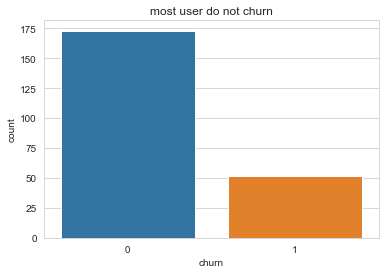

In [28]:
label_df = df_valid.select('userId','churn').dropDuplicates(subset=['userId']).groupBy('churn').count().toPandas()
sb.barplot(x='churn', y='count',data=label_df);
plt.title('most user do not churn');

可以看到没有churn的客户远多于churn的客户，label是偏态分布的，这可能会影响预测结果

#### 用户数量

In [29]:
user_count = df.select(countDistinct('userId').alias('user_count')).take(1)[0]['user_count']
print('用户数量：',user_count)

用户数量： 226


#### artist唯一值数数量

In [30]:
df_valid.where(df_valid['artist'].isNotNull()).groupby('artist').count().sort('count', ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|       Guns N' Roses|  713|
+--------------------+-----+
only showing top 20 rows



#### 最大length

In [31]:
print('最大长度：',df_valid.select(max('length')).take(1)[0]['max(length)'])

最大长度： 3024.66567


#### level的唯一值数量

In [32]:
df_valid.groupby('level').count().sort('count', ascending=False).show()

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+



#### method的唯一值数量

In [33]:
df_valid.groupby('method').count().sort('count', ascending=False).show()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



#### page的唯一值数量

In [34]:
df_valid.groupby('page').count().sort('count', ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|Cancellation Conf...|    52|
|              Cancel|    52|
+--------------------+------+



#### song的唯一值数量

In [35]:
df_valid.where(df_valid['song'].isNotNull()).groupby('song').count().sort('count', ascending=False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



status的唯一值数量

In [36]:
df_valid.groupby('status').count().sort('count', ascending=False).show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



#### userAgent的唯一值数量

In [37]:
df_valid.groupby('userAgent').count().sort('count', ascending=False).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                                  |count|
+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                            |22751|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                    |19611|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |18448|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Saf

gender的唯一值数量

In [38]:
df_valid.groupby('gender').count().sort('count', ascending=False).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



#### 每个小时的用户操作数量

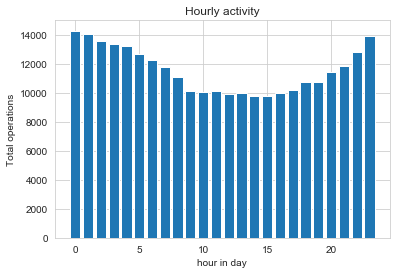

In [39]:
hourly_activity = df_valid.groupBy('hour').count().sort('hour').toPandas()
plt.bar(hourly_activity['hour'],hourly_activity['count'])
plt.title('Hourly activity');
plt.xlabel('hour in day');
plt.ylabel('Total operations');

所有用户的总操作次数在一定程度上可以代表用户的活跃度，从图中看出在凌晨24点用户的活跃度相对较高

### 双变量探索

#### 男性和女性的付费用户数量是多少，每个性别的付费比率是多少

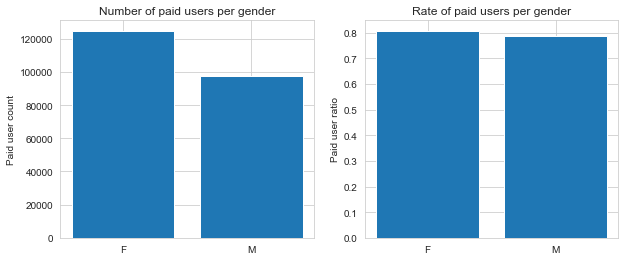

In [40]:
paid_count_per_gender = df_valid.groupBy('gender')\
    .agg(count(when(col('level')=='paid',col('level'))).alias('count')).toPandas()
paid_ratio_per_gender = df_valid.groupBy('gender')\
    .agg((count(when(col('level')=='paid',col('level'))) / count('userId')).alias('paid_ratio')).toPandas()
fig = plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
plt.bar(paid_count_per_gender['gender'],paid_count_per_gender['count']);
plt.title('Number of paid users per gender');
plt.ylabel('Paid user count');
plt.subplot(1, 2, 2)
plt.bar(paid_ratio_per_gender['gender'],paid_ratio_per_gender['paid_ratio']);
plt.title('Rate of paid users per gender');
plt.ylabel('Paid user ratio');

平台上女性付费用户比男性付费用户多，两个性别付费比率相差不多都是80%

#### 各地区的用户数量

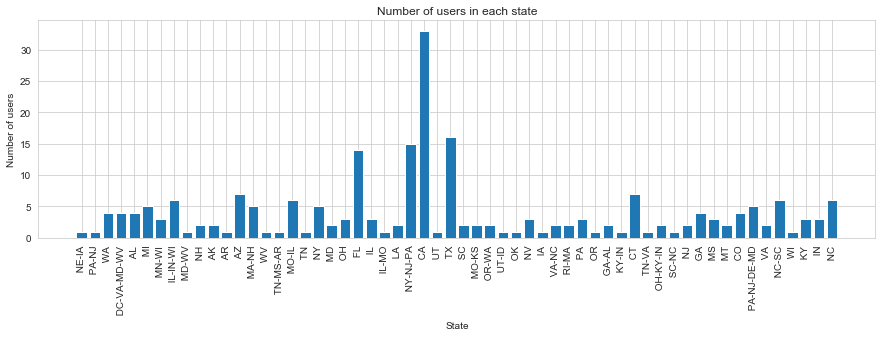

In [41]:
fig = plt.figure(figsize=(15,4))
state_user = df_valid.select('userId','location_state').dropDuplicates(subset=['userId'])\
    .groupBy('location_state').agg(count('userId').alias('user_count')).toPandas()
plt.bar(state_user['location_state'], state_user['user_count']);
plt.xticks(rotation = 90);
plt.title('Number of users in each state');
plt.xlabel('State');
plt.ylabel('Number of users');

加利福尼亚州的用户最多

#### 各个地区的付费用户数量，和付费用户比率

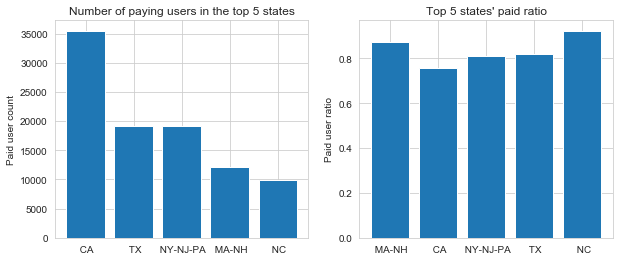

In [42]:
paid_count_per_state = df_valid.groupBy('location_state')\
    .agg(count(when(col('level')=='paid',col('level'))).alias('count'))\
    .sort('count',ascending=False).toPandas().head(5)
top5_state = list(paid_count_per_state['location_state'].head(5))
paid_ratio_per_state = df_valid.where(df_valid['location_state'].isin(top5_state))\
    .groupBy('location_state')\
    .agg((count(when(col('level')=='paid',col('level'))) / count('userId')).alias('paid_ratio'))\
    .toPandas()
fig = plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
plt.bar(paid_count_per_state['location_state'],paid_count_per_state['count']);
plt.title('Number of paying users in the top 5 states');
plt.ylabel('Paid user count');
plt.subplot(1, 2, 2)
plt.bar(paid_ratio_per_state['location_state'],paid_ratio_per_state['paid_ratio']);
plt.title("Top 5 states' paid ratio");
plt.ylabel('Paid user ratio');

加利福尼亚州的付费人数最多，付费排名前五的州的付费比率差不多都在80%左右

#### page和churn

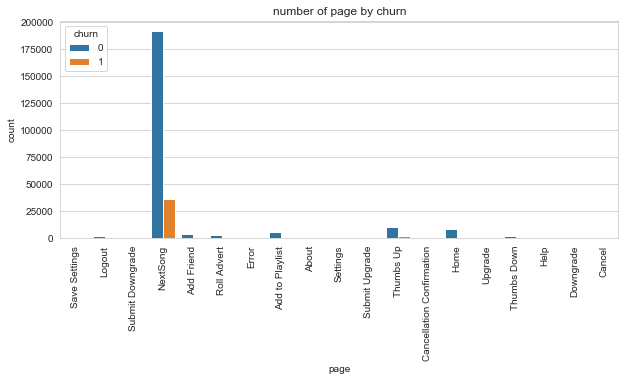

In [43]:
churn_page_number = df_valid.groupBy('churn','page').count().toPandas()
plt.figure(figsize=[10,4])
sb.barplot(data=churn_page_number, x='page', hue='churn', y='count');
plt.xticks(rotation=90);
plt.title('number of page by churn');

### 探索和churn相关的特征
通过从数据中提取用户的特征，观察用户特征和churn的关系

#### churn 和 status

In [44]:
status_churn_numbers = df_valid.groupBy('churn').pivot('status').count().toPandas()
print(status_churn_numbers)
status_churn_numbers.loc[2,:] = status_churn_numbers.loc[0,:] / status_churn_numbers.loc[1,:]

   churn     200    307  404
0      1   41137   3695   32
1      0  213581  19489  220


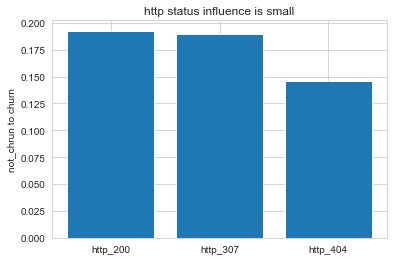

In [45]:
plt.bar(['http_200','http_307','http_404'], status_churn_numbers.loc[2:].iloc[0,[1,2,3]]);
plt.ylabel('not_chrun to churn');
plt.title('http status influence is small');

#### churn 和 level

In [46]:
# 计算paid和free的churn比率，保存在churn_ratio列
w = Window.partitionBy('level')
level_churn_ratio_df = df_valid.groupBy('churn','level').count()\
    .withColumn('total',fsum('count').over(w))\
    .select('churn','level',(col('count')/col('total')).alias('churn_ratio'))\
    .where(df_valid.churn==1)\
    .toPandas()

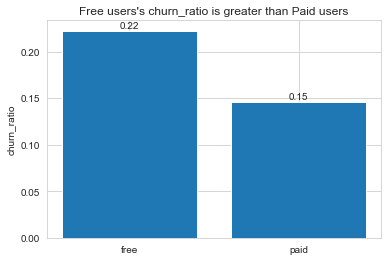

In [47]:
bar = plt.bar(level_churn_ratio_df['level'],level_churn_ratio_df['churn_ratio'])
for p in bar.patches:
    plt.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'top', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('churn_ratio');
plt.title("Free users's churn_ratio is greater than Paid users");

#### churn 和 gender

In [48]:
# 计算男女的churn比率，保存在churn_ratio列
w = Window.partitionBy('gender')
gender_churn_ratio_df = df_valid.groupBy('churn','gender').count()\
    .withColumn('total',fsum('count').over(w))\
    .select('churn','gender',(col('count')/col('total')).alias('churn_ratio'))\
    .where(df_valid.churn==1)\
    .toPandas()

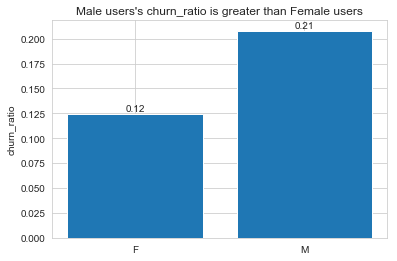

In [49]:
bar = plt.bar(gender_churn_ratio_df['gender'],gender_churn_ratio_df['churn_ratio'])
for p in bar.patches:
    plt.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'top', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('churn_ratio');
plt.title("Male users's churn_ratio is greater than Female users");

#### churn 和 用户注册时长

In [50]:
hours_since_reg_df = df_valid.select(((col('ts') - col('registration'))/1000/60/60)
                                     .alias('hours_since_reg'),'churn','userId')\
    .groupBy('churn','userId').agg(max('hours_since_reg'))\
    .withColumnRenamed('max(hours_since_reg)','hours_since_reg')\
    .toPandas()

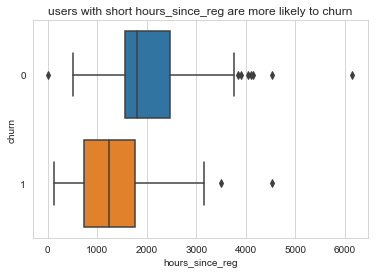

In [51]:
sb.boxplot('hours_since_reg', 'churn', data=hours_since_reg_df, orient="h");
plt.title('users with short hours_since_reg are more likely to churn');

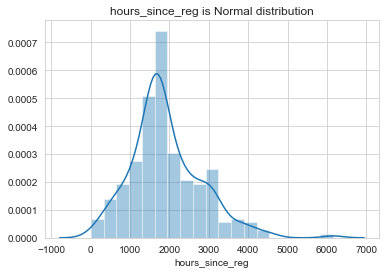

In [52]:
sb.distplot(hours_since_reg_df['hours_since_reg']);
plt.title('hours_since_reg is Normal distribution');

#### churn 和 用户会话会中song数量的均值

In [53]:
avg_song_count_df = df_valid.where(df_valid['song'] != '')\
    .groupBy('userId','sessionId','churn')\
    .agg(count('song').alias('song_count'))\
    .groupBy('userId','churn')\
    .agg(avg('song_count').alias('avg_song_count'))\
    .select('churn','avg_song_count').toPandas()

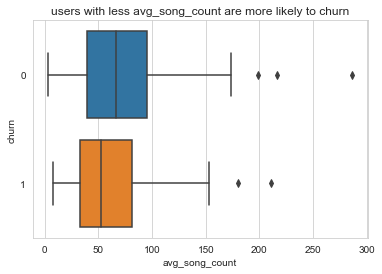

In [54]:
sb.boxplot('avg_song_count','churn',data=avg_song_count_df, orient="h");
plt.title('users with less avg_song_count are more likely to churn');

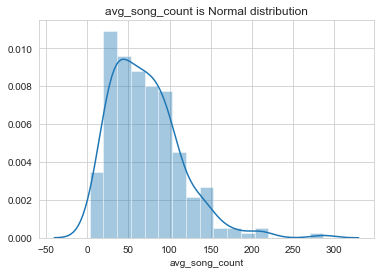

In [55]:
sb.distplot(avg_song_count_df['avg_song_count']);
plt.title('avg_song_count is Normal distribution');

#### churn 和 用户的会话数量

In [56]:
session_per_user_df = df_valid.groupBy('userId','churn')\
    .agg(countDistinct('sessionId').alias('unique_session'))\
    .withColumn('unique_session_sqrt',sqrt('unique_session'))\
    .toPandas()

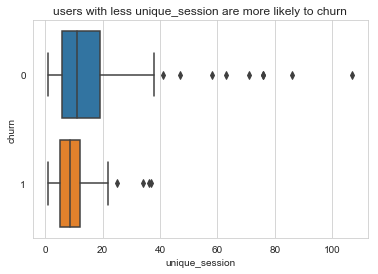

In [57]:
sb.boxplot('unique_session','churn',data=session_per_user_df, orient="h");
plt.title('users with less unique_session are more likely to churn');

In [58]:
session_per_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 4 columns):
userId                 225 non-null object
churn                  225 non-null int32
unique_session         225 non-null int64
unique_session_sqrt    225 non-null float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 6.2+ KB


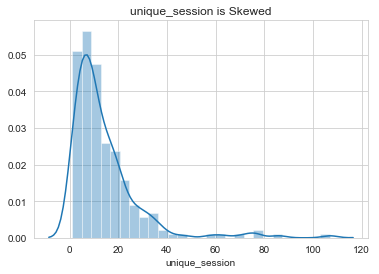

In [59]:
sb.distplot(session_per_user_df['unique_session']);
plt.title('unique_session is Skewed');

会话数量是偏态分布的，这里进行开平方处理，处理后近似正态分布。

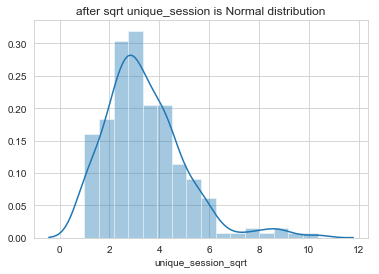

In [60]:
sb.distplot(session_per_user_df['unique_session_sqrt']);
plt.title('after sqrt unique_session is Normal distribution');

#### churn 和 用户将歌曲添加到播放列表的数量

In [61]:
play_list_df = df_valid.where(df_valid.page=='Add to Playlist')\
    .groupBy('userId','churn').agg(count('userId').alias('num_playlist'))\
    .withColumn('num_playlist_sqrt',sqrt('num_playlist'))\
    .toPandas()

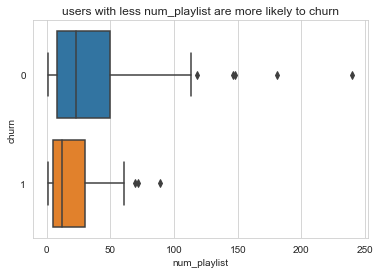

In [62]:
sb.boxplot('num_playlist','churn',data=play_list_df, orient="h");
plt.title('users with less num_playlist are more likely to churn');

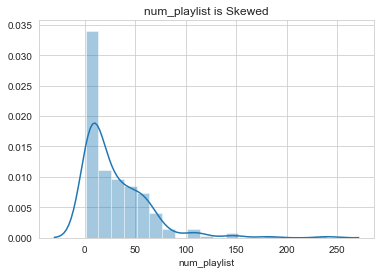

In [63]:
sb.distplot(play_list_df['num_playlist']);
plt.title('num_playlist is Skewed');

添加到播放列表的数量是偏态分布的，这里进行开平方处理，处理后近似正态分布。

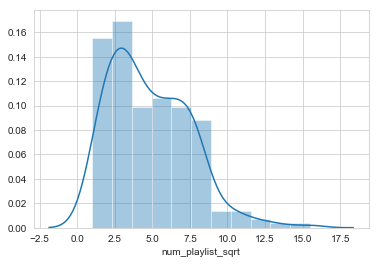

In [64]:
sb.distplot(play_list_df['num_playlist_sqrt']);

#### churn 和 用户添加好友数量

In [65]:
add_friend_df = df_valid.where(df_valid.page=='Add Friend')\
    .groupBy('userId','churn').agg(count('userId').alias('num_friend'))\
     .withColumn('num_friend_sqrt',sqrt('num_friend'))\
    .toPandas()

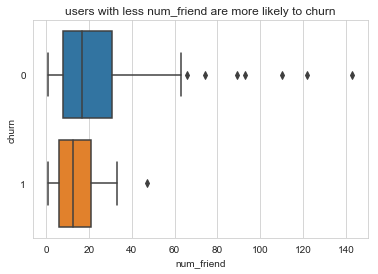

In [66]:
sb.boxplot('num_friend','churn',data=add_friend_df, orient="h");
plt.title('users with less num_friend are more likely to churn');

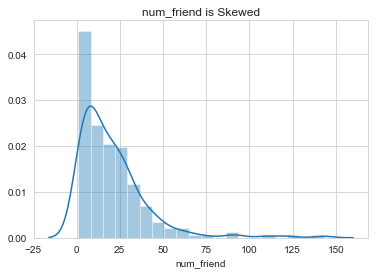

In [67]:
sb.distplot(add_friend_df['num_friend']);
plt.title('num_friend is Skewed');

好友数量是偏态分布的，这里进行开平方处理，处理后近似正态分布。

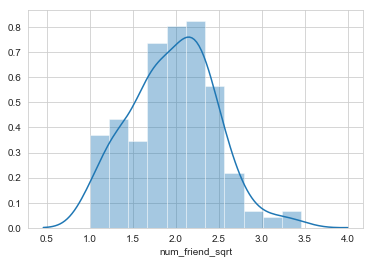

In [68]:
sb.distplot(np.sqrt(add_friend_df['num_friend_sqrt']));

#### churn 和 没有听歌曲的比率

In [69]:
row_count = df_valid.groupBy('userId','churn').agg(count('length').alias('row_count'))
length_count = df_valid.groupBy('userId').count()
null_ratio_df = row_count.join(length_count,row_count.userId==length_count.userId,'inner')\
    .withColumn('null_ratio',(1-(col('row_count')/col('count'))))\
    .select('churn','null_ratio').toPandas()

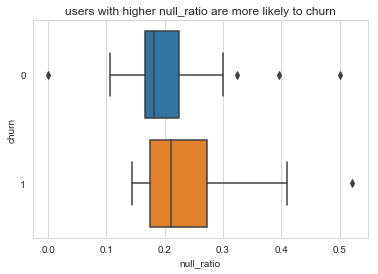

In [70]:
sb.boxplot('null_ratio','churn', data=null_ratio_df, orient="h");
plt.title('users with higher null_ratio are more likely to churn');

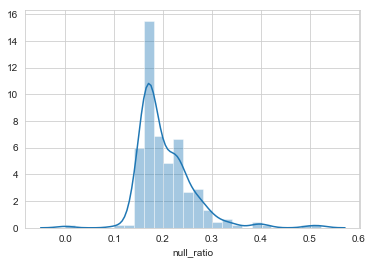

In [71]:
sb.distplot(null_ratio_df['null_ratio']);

#### churn 和 最大itemInSession

itemInSession 与 sessionId有密切关系，itemInSession表示每个sessionId中有多少个item，通过观察某个sessionId的数据，发现itemInSession是递增的，这应该是统计的日志写入那一时刻session中的item数量，单看此列没有意义，这里计算会话中item的实际数量的最大值，观察该最大值与churn的关系。

In [72]:
max_itemInSession_df = df_valid\
    .groupBy('churn','userId','sessionId')\
    .agg(max('itemInSession').alias('totalItemInSession'))\
    .groupBy('churn','userId')\
    .agg(max('totalItemInSession').alias('maxItemInSession'))\
    .withColumn('maxItemInSession_sqrt',sqrt('maxItemInSession'))\
    .toPandas()

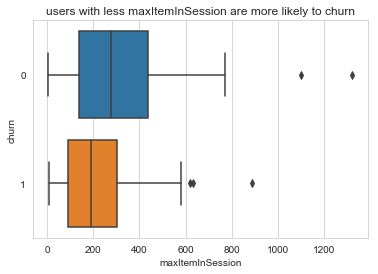

In [73]:
sb.boxplot('maxItemInSession','churn',data=max_itemInSession_df, orient="h");
plt.title('users with less maxItemInSession are more likely to churn');

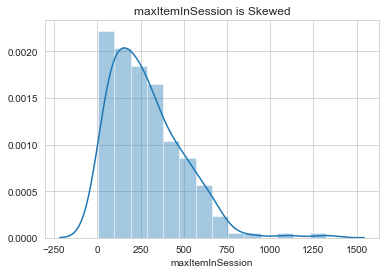

In [74]:
sb.distplot(max_itemInSession_df['maxItemInSession']);
plt.title('maxItemInSession is Skewed');

该特征是偏态分布的，这里进行开平方处理，处理后近似正态分布。

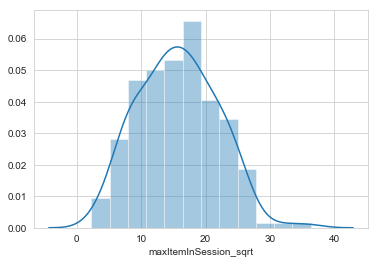

In [75]:
sb.distplot(max_itemInSession_df['maxItemInSession_sqrt']);

## 特征工程
选取了探索过的9个特征作为算法的输入，将特征和标签保存在df_features中

In [76]:
# 用户的level
f1 = df_valid.select('userId','level').dropDuplicates(subset=['userId'])

In [77]:
# 用户的性别
f2 = df_valid.select('userId','gender').dropDuplicates(subset=['userId'])

In [78]:
# 用户注册时长
f3 = df_valid.select(((col('ts') - col('registration'))/1000/60/60).alias('hours_since_reg'),'userId')\
    .groupBy('userId').agg(max('hours_since_reg'))\
    .withColumnRenamed('max(hours_since_reg)','hours_since_reg')

In [79]:
# 用户所有会话听的歌曲数量均值
f4 = avg_song_count_df = df_valid.where(df_valid['song'] != '')\
    .groupBy('userId','sessionId')\
    .agg(count('song').alias('song_count'))\
    .groupBy('userId')\
    .agg(avg('song_count').alias('avg_song_count'))

In [80]:
# 用户的会话数量
f5 = df_valid.groupBy('userId')\
    .agg(countDistinct('sessionId').alias('unique_session_num'))\
    .withColumn('unique_session_num_sqrt',sqrt('unique_session_num'))

In [81]:
# 用户将歌曲添加到播放列表的数量
f6 = df_valid.where(df_valid.page=='Add to Playlist')\
    .groupBy('userId').agg(count('page').alias('add_playlist_num'))\
    .withColumn('num_playlist_sqrt',sqrt('add_playlist_num'))

In [82]:
# 用户添加好友数量
f7 = df_valid.where(df_valid.page=='Add Friend')\
    .groupBy('userId').agg(count('page').alias('add_friend_num'))\
    .withColumn('add_friend_num_sqrt',sqrt('add_friend_num'))

In [83]:
# 没有听歌曲的比率
row_count = df_valid.groupBy('userId').agg(count('length').alias('row_count'))
length_count = df_valid.groupBy('userId').count()
f8 = row_count.join(length_count, 'userId','inner')\
    .withColumn('null_ratio',(1-(col('row_count')/col('count'))))\
    .select('userId','null_ratio')

In [84]:
# 最大itemInSession
f9 = df_valid\
    .groupBy('userId','sessionId')\
    .agg(max('itemInSession').alias('totalItemInSession'))\
    .groupBy('userId').agg(max('totalItemInSession').alias('maxItemInSession'))\
    .withColumn('maxItemInSession_sqrt',sqrt('maxItemInSession'))

In [85]:
label = df_valid.select('userId',col('churn').alias('label')).dropDuplicates(subset=['userId'])

In [86]:
df_features = f1.join(f2,'userId','outer')\
    .join(f3,'userId','outer')\
    .join(f4,'userId','outer')\
    .join(f5,'userId','outer')\
    .join(f6,'userId','outer')\
    .join(f7,'userId','outer')\
    .join(f8,'userId','outer')\
    .join(f9,'userId','outer')\
    .join(label,'userId','outer')\
    .fillna(0).drop('userId').persist()
df_features.show(n=1,vertical=True)
print('样本数量：{}'.format(df_features.count()))

-RECORD 0-------------------------------------
 level                   | free               
 gender                  | F                  
 hours_since_reg         | 1335.447777777778  
 avg_song_count          | 39.285714285714285 
 unique_session_num      | 7                  
 unique_session_num_sqrt | 2.6457513110645907 
 add_playlist_num        | 7                  
 num_playlist_sqrt       | 2.6457513110645907 
 add_friend_num          | 4                  
 add_friend_num_sqrt     | 2.0                
 null_ratio              | 0.2782152230971129 
 maxItemInSession        | 111                
 maxItemInSession_sqrt   | 10.535653752852738 
 label                   | 0                  
only showing top 1 row

样本数量：225


# 建模
此部分将数据集分成训练集、测试集和验证集，使用F1 score 评估了四个算法：逻辑回归，GBT，支持向量机，随机森林。使用k折交叉验证选出表现最好的算法，然后使用网格搜索调整超参数训练出在训练集上表现最好的模型，最后用该模型在测试集上进行验证。

### 评估指标
由于label是偏态的，且阳性(churn=1)占少数，使用F1 score作为评估指标

### 划分数据集
60%作为训练集，20%作为验证集，20%作为测试集

In [87]:
train, rest = df_features.randomSplit([0.6, 0.4], seed=42)
test, validation = rest.randomSplit([0.5, 0.5], seed=42)

### 基准模型
将训练集中的数据全部预测为0，或者全部预测为1，作为基准模型

In [88]:
evaluator = MulticlassClassificationEvaluator()

In [89]:
results_1 = test.withColumn('prediction', lit(1.0))
print('Accuracy: {}'.format(evaluator.evaluate(results_1, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_1, {evaluator.metricName: "f1"})))

Accuracy: 0.2
F1 Score:0.06666666666666667


In [90]:
results_0 = test.withColumn('prediction', lit(0.0))
print('Accuracy: {}'.format(evaluator.evaluate(results_0, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_0, {evaluator.metricName: "f1"})))

Accuracy: 0.8
F1 Score:0.7111111111111111


预测全部都是0的基准模型在测试集上也有较好表现

### 模型选择
使用了pipeline (pipeline包含特征预处理)。使用交叉验证评估了四个模型，选择在验证集上表现最好的模型。

In [91]:
# 定义使用的feature列表
features = ['avg_song_count','unique_session_num','add_playlist_num','add_friend_num','maxItemInSession',
            'null_ratio','hours_since_reg','gender_index','level_index']
features_sqrt = ['avg_song_count','unique_session_num_sqrt','num_playlist_sqrt','add_friend_num_sqrt',
            'maxItemInSession_sqrt','null_ratio','hours_since_reg','gender_index','level_index']

# 使用StringIndexer处理分类变量
indexer_gender = StringIndexer(inputCol="gender", outputCol="gender_index")
indexer_level = StringIndexer(inputCol="level", outputCol="level_index")
# 创建特征向量
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
assembler_sqrt = VectorAssembler(inputCols=features_sqrt, outputCol="NumFeatures_sqrt")
# 使用StandardScaler缩放特征
scaler_ss = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures_ss", withStd=True, withMean=False)
scaler_ss_sqrt = StandardScaler(inputCol="NumFeatures_sqrt", outputCol="ScaledNumFeatures_ss_sqrt", withStd=True, withMean=False)
# 定义评估器
evaluator = MulticlassClassificationEvaluator()
# 定义网格搜索参数
paramGrid = ParamGridBuilder().build()

#### LogisticRegression

In [92]:
balancing_ratio = train.filter(train['label']==0).count()/train.count()
train = train.withColumn("classWeights", when(train.label == 1,balancing_ratio).otherwise(1-balancing_ratio))

In [93]:
# 初始化逻辑回归
lr = LogisticRegression(maxIter=10,featuresCol='ScaledNumFeatures_ss', labelCol='label', weightCol='classWeights')
# 定义逻辑回归的pipeline
pipeline_lr = Pipeline(stages=[indexer_gender, indexer_level, assembler, scaler_ss, lr])
s = time()
Model_lr = pipeline_lr.fit(train)
# 使用逻辑回归pipeline拟合训练数据
e = time()
print('time used:',e-s)

time used: 20.320687294006348


In [94]:
lr_result = Model_lr.transform(validation)
print('f1 score:',evaluator.evaluate(lr_result, {evaluator.metricName: "f1"}))
print('accuracy:',evaluator.evaluate(lr_result, {evaluator.metricName: "accuracy"}))

f1 score: 0.6864612511671336
accuracy: 0.6617647058823529


由于特征中有偏态数据，偏态特征违反了逻辑回归的假设，这里逻辑回归使用了开平方后的特征又拟合了一遍，accuracy和f1 score有所提升

In [95]:
# 初始化逻辑回归
lr_sqrt = LogisticRegression(maxIter=10,featuresCol='ScaledNumFeatures_ss_sqrt', labelCol='label', weightCol='classWeights')
# 定义逻辑回归的pipeline
pipeline_lr_sqrt = Pipeline(stages=[indexer_gender, indexer_level, assembler_sqrt, scaler_ss_sqrt, lr_sqrt])
s = time()
Model_lr_sqrt = pipeline_lr_sqrt.fit(train)
# 使用逻辑回归pipeline拟合训练数据
e = time()
print('time used:',e-s)

time used: 19.47185516357422


In [96]:
lr_result_sqrt = Model_lr_sqrt.transform(validation)
print('f1 score:',evaluator.evaluate(lr_result_sqrt, {evaluator.metricName: "f1"}))
print('accuracy:',evaluator.evaluate(lr_result_sqrt, {evaluator.metricName: "accuracy"}))

f1 score: 0.7380200860832138
accuracy: 0.7205882352941176


#### GBDT

In [97]:
# 初始化GBT
gbt = GBTClassifier(maxIter=10,featuresCol='ScaledNumFeatures_ss',labelCol='label', seed=42)
# 定义GBT的pipeline
pipeline_gbt = Pipeline(stages=[indexer_gender, indexer_level, assembler, scaler_ss, gbt])
s = time()
# 使用GBT的ipeline拟合训练数据
Model_gbt = pipeline_gbt.fit(train)
e = time()
print('time used:',e-s)

time used: 87.31449222564697


In [98]:
gbt_result = Model_gbt.transform(validation)
print('f1 score:',evaluator.evaluate(gbt_result, {evaluator.metricName: "f1"}))
print('accuracy:',evaluator.evaluate(gbt_result, {evaluator.metricName: "accuracy"}))

f1 score: 0.7116493656286045
accuracy: 0.7058823529411765


#### Support Vector Machine

In [99]:
# 初始化支持向量机
svm = LinearSVC(maxIter=10,featuresCol='ScaledNumFeatures_ss',labelCol='label' ,weightCol='classWeights')
# 定义SVM的pipeline
pipeline_svm = Pipeline(stages=[indexer_gender, indexer_level, assembler, scaler_ss, svm])
s = time()
# 使用SVM的pipeline拟合训练数据
Model_svm = pipeline_svm.fit(train)
e = time()
print('time used:',e-s)

time used: 41.38533282279968


In [100]:
svm_result = Model_svm.transform(validation)
print('f1 score:',evaluator.evaluate(svm_result, {evaluator.metricName: "f1"}))
print('accuracy:',evaluator.evaluate(svm_result, {evaluator.metricName: "accuracy"}))

f1 score: 0.6448500348756103
accuracy: 0.6176470588235294


#### Random Forest

In [101]:
# 初始化随机森林
rf = RandomForestClassifier(featuresCol='ScaledNumFeatures_ss',labelCol='label', seed=42)
# 定义随机森林的pipeline
pipeline_rf = Pipeline(stages=[indexer_gender, indexer_level, assembler, scaler_ss, rf])
s = time()
# 使用随机森林pipeline拟合训练数据
Model_rf = pipeline_rf.fit(train)
e = time()
print('time used:',e-s)

time used: 25.392884016036987


In [102]:
rf_result = Model_rf.transform(validation)
print('f1:',evaluator.evaluate(rf_result, {evaluator.metricName: "f1"}))
print('accuracy:',evaluator.evaluate(rf_result, {evaluator.metricName: "accuracy"}))

f1: 0.8141923436041085
accuracy: 0.8235294117647058


默认参数的模型在验证集上的表现：

逻辑回归：
- f1 score: 0.7380200860832138
- accuracy: 0.7205882352941176

GBT：
- f1 score: 0.7116493656286045
- accuracy: 0.7058823529411765

支持向量机：
- f1 score: 0.6828664199954693
- accuracy: 0.6617647058823529

随机森林：

- f1: 0.8141923436041085
- accuracy: 0.8235294117647058

**可以看到随机森林相比其他三个有更高的F1得分，所以下一步用随机森林进行参数调整。**

### 调整模型参数
#### 在随机森林上算法上使用网格搜索进行超参数选择

In [103]:
rf = RandomForestClassifier(featuresCol='ScaledNumFeatures_ss',labelCol='label', seed=42)
paramGrid_tune = ParamGridBuilder() \
    .addGrid(rf.numTrees, [4,6,8]) \
    .addGrid(rf.maxDepth, [4,6,8]) \
    .build()
evaluator = MulticlassClassificationEvaluator()
pipeline_rf = Pipeline(stages=[indexer_gender, indexer_level, assembler, scaler_ss, rf])
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_tune,
                          evaluator=evaluator,
                          numFolds=3)
s = time()
cvModel_rf_tune = crossval.fit(train)
e = time()
print('time used:',e-s)
print('cv average f1_score',cvModel_rf_tune.avgMetrics)

time used: 550.6245579719543
cv average f1_score [0.7084372180957107, 0.7047462800307814, 0.7008741053176923, 0.7437405000567923, 0.7204292598562235, 0.7176229161472221, 0.7796508762658906, 0.7924075569793241, 0.7951241083459011]


In [104]:
best_rf_result_tune = cvModel_rf_tune.bestModel.transform(test)
best_rf_result_tune_df = best_rf_result_tune.toPandas()
print('f1:',evaluator.evaluate(best_rf_result_tune, {evaluator.metricName: "f1"}))
print('accuracy:',evaluator.evaluate(best_rf_result_tune, {evaluator.metricName: "accuracy"}))

f1: 0.784
accuracy: 0.8


In [105]:
metrics.confusion_matrix(best_rf_result_tune_df['label'], best_rf_result_tune_df['prediction'], labels=[1,0])

array([[ 1,  2],
       [ 1, 11]])

调整后的模型在测试机上的F1 score是0.784，accuracy是0.8，在测试集的15个样本中，有2个真实是1被预测为0，有1个真实是0被预测为1。最终结果的F1 socre比基准模型(F1 score:0.71)有提高，但是提高并不多。

#### 调整threshold：
在训练集上选择(tpr-fpr)值最大的阈值，将该阈值作为测试集的分界

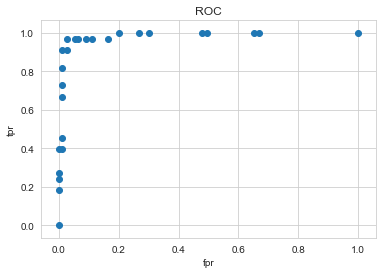

In [106]:
# 使用训练好的模型预测训练数据
best_rf_result_tune_train = cvModel_rf_tune.bestModel.transform(train)
best_rf_result_tune_train_df = best_rf_result_tune_train.toPandas()
# 绘制ROC曲线
fpr, tpr, thresholds = metrics.roc_curve(best_rf_result_tune_train_df['label'],
                                         best_rf_result_tune_train_df['probability'].map(lambda x:x[1]),
                                         pos_label=1)
plt.scatter(fpr,tpr);
plt.xlabel('fpr');
plt.ylabel('tpr');
plt.title('ROC');

In [107]:
# 将tpr-fpr最大的阈值应用到测试集
threshold = thresholds[np.argmax(tpr - fpr)]
prob = best_rf_result_tune_df['probability'].map(lambda x:x[1])
best_rf_result_tune_df['prediction_'] = (prob>=threshold).map(lambda x:1 if x else 0)

In [108]:
print('选择阈值前f1得分：',metrics.f1_score(best_rf_result_tune_df['label'],best_rf_result_tune_df['prediction'],
                                    average="weighted"))
print('选择阈值后f1得分',metrics.f1_score(best_rf_result_tune_df['label'],best_rf_result_tune_df['prediction_'],
                                   average="weighted"))

选择阈值前f1得分： 0.7839999999999999
选择阈值后f1得分 0.7333333333333333


使用选择选择的阈值，测试集的f1得分反而下降了。接下来查看不同threshold下的precision和recall

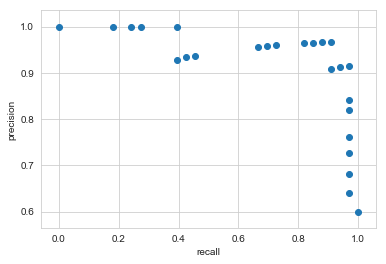

In [109]:
# 绘制precision,recall曲线
precision, recall, thresholds = metrics.precision_recall_curve(best_rf_result_tune_train_df['label'],
                                         best_rf_result_tune_train_df['probability'].map(lambda x:x[1]),
                                         pos_label=1)
plt.scatter(recall,precision);
plt.xlabel('recall');
plt.ylabel('precision');

如果错过流失的用户比挽留本来不会流失的用户问题严重，可以适当牺牲一些Precision，换取高的recall

## 特征重要性

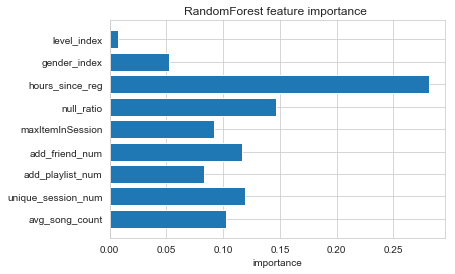

In [110]:
best_model = cvModel_rf_tune.bestModel.stages[-1]
importance = best_model.featureImportances.values
feature_index = best_model.featureImportances.indices
features = pd.Series(['avg_song_count','unique_session_num','add_playlist_num','add_friend_num','maxItemInSession',
            'null_ratio','hours_since_reg','gender_index','level_index'])
plt.barh(list(features[feature_index]) ,importance);
plt.title('RandomForest feature importance ')
plt.xlabel('importance');

随机森林的feature_importance显示hour_since_reg对于用户是否会churn有着很大的影响，这是合理的，因为注册的时间长的用户代表用户在很长时间内都没有注销其账号，可能是经常使用，这样的用户更不容易注销账号，但也可能是很久以前注册过一直没用，也没有注销。

## 结论

这个notebook在128M的数据上训练了用于预测用户是否会churn的模型，评估了四个模型：逻辑回归，GBT，支持向量机，随机森林，通过对比F1 socre选择了随机森林并在其上调整参数，使用最优模型在测试集上得到的F1 score 是0.784，准确率是0.8，但是测试集只有15个样本，所以在测试集上的到的得分有较大偏差。最后列出随机森林给出的对于用户是否会churn的最重要特征是用户注册了多长时间(hour_since_reg)。此notebook使用的是数据的子集，这样才能在单台机器上运行，如果用完整数据(12G)，对于现有机器性能已经是大数据，需要在集群环境运行。数据有只225个用户样本，所以模型实际意义并不大，如果有更多数据，可以将本notebook拓展到spark环境，将对模型表现有很大程度的提升。

### 难点

我通过可视化的方式选择了特征，但是如何判断特征是否真对于预测label有用，并没有指标作为界定。[这篇文章](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)提到，特征选择主要有两种方法：filter method 和 Wrapper methods。filter method方法使用统计技术评估每个输入变量和目标变量之间的关系，然后排序算法过滤那些有用性较低的特征，对于分类-数据类型的数据，可以使用F-检验，对于分类-分类数据，可以使用卡方检验。Wrapper methods通常通过直接测试特征对模型性能的影响来选择特征。另外一个难点是标签和某些特征是偏态的，偏态分布的尾部可以作为异常值，[异常值不利于模型的表现](https://discuss.analyticsvidhya.com/t/effects-of-outliers-on-regression-model/2403)，虽然tree-based模型对异常值有较好的鲁棒性，但也限制了我们的选择。如果标签的偏态的，模型将会大量在多数标签上训练，较少在少数标签上训练，这样模型可能会不容易识别出较少标签的分类。

### 可以改进的地方

我提取了9个特征用来预测用户的流失，可能还有更好的特征，如果加以尝试相信会提高模型的得分。另外我对数据集的划分只做了一次，这一次划分的数据得到模型并不一定是最好的模型，可以对数据集尝试多划分几次，然后选择得分最高的模型。